## **SegSalad: A Hands On Review of Semantic Segmentation Techniques for Weed/Crop Datasets**
By Rehaan M. Bhimani

## Lets Set Up Colab to work with our Neural Networks and Data


In [ ]:
# Import relevant packages and set device to CUDA if available
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage import io


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

cuda


In [ ]:
# Mount our Google Drive to keep track of checkpoints and data
import os
from google.colab import drive
drive.mount('/content/drive')
checkpoints = '/content/drive/MyDrive/colab_files/SegSalad/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Download Data from Github
import os
import shutil
if not os.path.exists('SegSalad'):
  if not os.path.exists(checkpoints + 'dataset'):
    print("Downloading archive...")
    os.chdir(checkpoints)
    !git clone https://github.com/bhimar/cwfid-dataset.git
    os.chdir('/content/')
  print("Copying to local runtime...")
  if not os.path.exists('./dataset'):
    shutil.copytree(checkpoints + 'dataset', './dataset')
print("Data ready!")


Copying to local runtime...
Data ready!


In [ ]:
# Create paths with image and annotation paths

!ls dataset/images/*.png > images.txt
!ls dataset/annotations/*.png > annotations.txt
print('image path files creates')

image path files creates


## How are the annotations represented?
We see that the pixels with value 255 in the red channel correspond to weeds, and the pixels with value 255 in the green channel correspond to crops. We are going to make the background blue for training and visualization purposes.

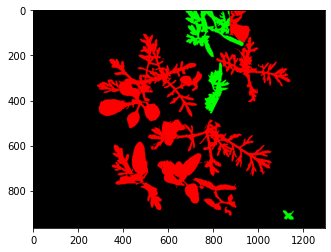

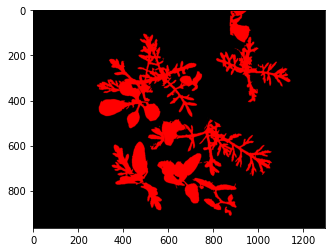

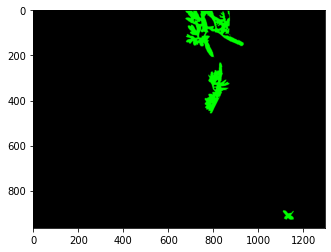

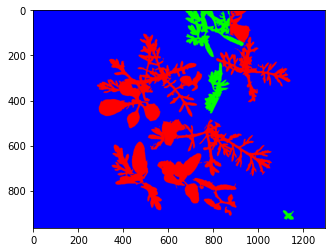

In [ ]:
# import and display annotation
image = io.imread('dataset/annotations/001_annotation.png')
plt.figure(0)
plt.imshow(image)

# display weeds
imtensor = torch.tensor(image)
imtensor_red = imtensor.clone().detach()
imtensor_red[:,:,1] = 0 # remove any green
plt.figure(1)
plt.imshow(imtensor_red)

# display crops
imtensor_green = imtensor.clone().detach()
imtensor_green[:,:,0] = 0 # remove any red
plt.figure(2)
plt.imshow(imtensor_green)

# set background to blue
imtensor_final = imtensor.clone().detach()
max, ind = torch.max(imtensor, dim=2)
toblue = max==0
imtensor_final[:,:,2] = toblue.float() * 255
plt.figure(3)
plt.imshow(imtensor_final)

## Time to define our dataset


In [ ]:
class WeedCropDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, images_file, transform=None):
      with open(annotations_file) as f:
        self.annotations = [line.rstrip() for line in f]
      with open(images_file) as f:
        self.images = [line.rstrip() for line in f]
      print('Annotations: ' + str(self.annotations))
      print('Images: '+ str(self.images))
      self.transform = transform

    def __len__(self):
      return len(self.images)

    def __getitem__(self, idx):
      image = io.imread(self.images[idx])
      imtensor = torch.tensor(image) / 255.0 # normalize to values between 0 and 1
      annotation = io.imread(self.annotations[idx])
      annotation = torch.tensor(annotation)
      max, ind = torch.max(annotation, dim=2)
      toblue = max==0
      annotation[:,:,2] = toblue.float() * 255
      antensor = annotation / 255.0 # normalize to values of 0 and 1

      imtensor = imtensor.permute(2,0,1) # convert to C x H x W orientation
      antensor = antensor.permute(2,0,1)
      if self.transform:
            imtensor = self.transform(imtensor)
      sample = {'image': imtensor, 'annotation': antensor}
      return sample



### Lets use dataloaders to inspect our dataset

Annotations: ['dataset/annotations/001_annotation.png', 'dataset/annotations/002_annotation.png', 'dataset/annotations/003_annotation.png', 'dataset/annotations/004_annotation.png', 'dataset/annotations/005_annotation.png', 'dataset/annotations/006_annotation.png', 'dataset/annotations/007_annotation.png', 'dataset/annotations/008_annotation.png', 'dataset/annotations/009_annotation.png', 'dataset/annotations/010_annotation.png', 'dataset/annotations/011_annotation.png', 'dataset/annotations/012_annotation.png', 'dataset/annotations/013_annotation.png', 'dataset/annotations/014_annotation.png', 'dataset/annotations/015_annotation.png', 'dataset/annotations/016_annotation.png', 'dataset/annotations/017_annotation.png', 'dataset/annotations/018_annotation.png', 'dataset/annotations/019_annotation.png', 'dataset/annotations/020_annotation.png', 'dataset/annotations/021_annotation.png', 'dataset/annotations/022_annotation.png', 'dataset/annotations/023_annotation.png', 'dataset/annotations

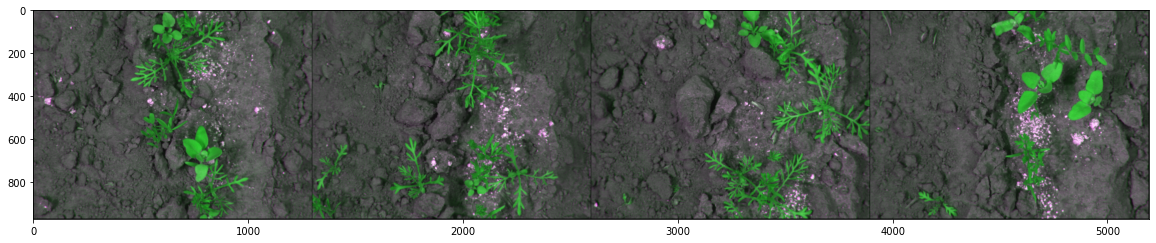

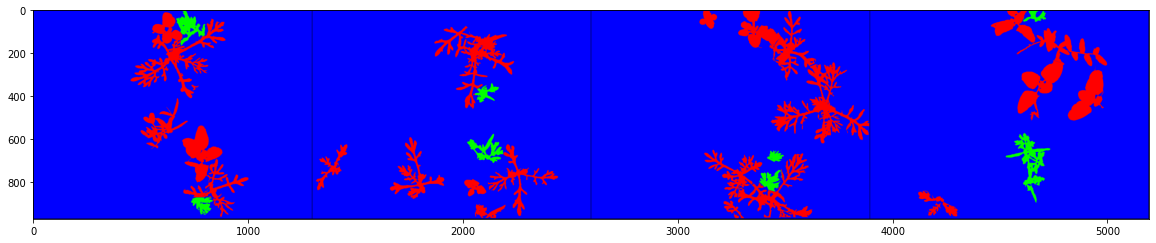

Image and Annotation Dimensions:
torch.Size([3, 966, 1296]) torch.Size([3, 966, 1296])


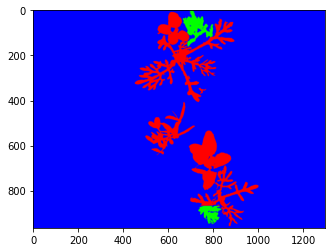

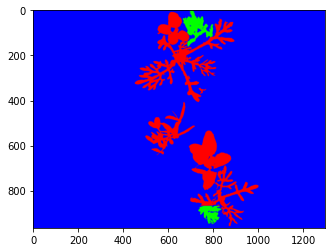

In [ ]:
# Load the dataset
dataset = WeedCropDataset('annotations.txt', 'images.txt')

# split into training and testing data
train_len = int(0.8 * len(dataset))
test_len = len(dataset) - train_len
train_set, test_set = torch.utils.data.random_split(dataset, [train_len, test_len])
print('train set length: ' + str(len(train_set)))
print('test set length: ' + str(len(test_set)))

# define dataloaders
trainloader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)

# visualize some images
trainiter = iter(trainloader)
batch = trainiter.next()
images = batch['image']
annotations = batch['annotation']

plt.figure(0, figsize=(20,20))
imshow(torchvision.utils.make_grid(images))
plt.figure(1, figsize=(20,20))
imshow(torchvision.utils.make_grid(annotations))

# print image dimensions
img = images[0]
annot = annotations[0]
print("Image and Annotation Dimensions:")
print(img.shape, annot.shape)

# how will we reconstruct the image from network output
classes = torch.argmax(annot, dim=0)
r = torch.zeros_like(classes)
g = torch.zeros_like(classes)
b = torch.zeros_like(classes)

idx = classes == 0
r[idx] = 1
idx = classes == 1
g[idx] = 1
idx = classes == 2
b[idx] = 1
  
rgb = torch.stack([r, g, b], axis=0)
imshow(annot)
imshow(rgb * 255)

## Data Augmentation: patching images
Because our images are very high resolution and we only have a few of them, we split each image into 3x224x224 patches before feeding them to the network. An example is show below (notice there is some cropping of the original image).

torch.Size([4, 3, 966, 1296])


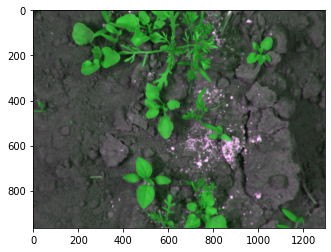

torch.Size([4, 150528, 20]) torch.Size([4, 150528, 20])


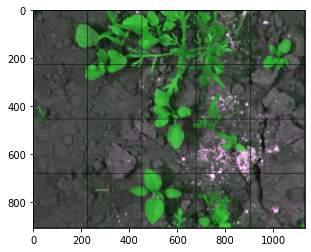

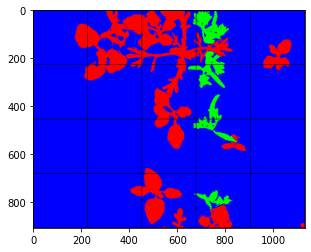

torch.Size([80, 3, 224, 224])


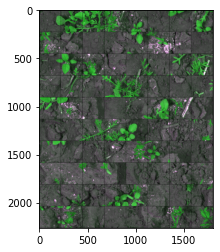

torch.Size([80, 3, 224, 224])


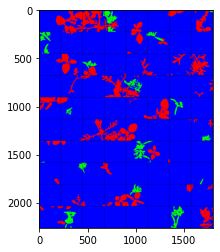

torch.Size([1, 150528, 20])
torch.Size([1, 3, 896, 1120])


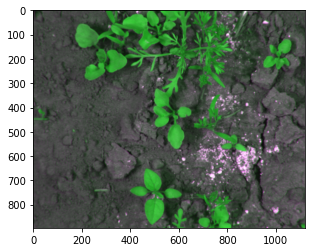

In [ ]:
trainiter = iter(trainloader)
batch = trainiter.next()
images = batch['image']
print(images.shape)
annot = batch['annotation']

image = images[0]
# plot original image (1st image in batch)
imshow(image)

# split up into patches
patch_size = 224
stride = 224
img_patches = F.unfold(images, patch_size, stride=stride)
annot_patches = F.unfold(annot, patch_size, stride=stride)
print(img_patches.shape, annot_patches.shape) # Batch size x (C x H x W) x # patches

pre_recon = img_patches[0]
split_img = img_patches[0]
split_annot = annot_patches[0]
split_img = split_img.transpose(0,1)
split_img = split_img.view(20,3,224,224)
split_annot = split_annot.transpose(0,1)
split_annot = split_annot.view(20,3,224,224)

imshow(torchvision.utils.make_grid(split_img, nrow=5))
imshow(torchvision.utils.make_grid(split_annot, nrow=5))

# while training we want to have a whole batch in (Batch size x # patches) x 3 x H x W
patch_num = img_patches.shape[2]
batch_size = img_patches.shape[0]
img_size = img_patches.shape[1]
img_patches = img_patches.permute(0,2,1)
img_patches = img_patches.reshape(patch_num * batch_size,  img_size)
img_patches = img_patches.view(patch_num * batch_size, 3, patch_size, patch_size)
print(img_patches.shape)
imshow(torchvision.utils.make_grid(img_patches))

annot_size = annot_patches.shape[1]
annot_patches = annot_patches.permute(0,2,1)
annot_patches = annot_patches.reshape(patch_num * batch_size,  img_size)
annot_patches = annot_patches.view(patch_num * batch_size, 3, patch_size, patch_size)
print(annot_patches.shape)
imshow(torchvision.utils.make_grid(annot_patches))

# We will need to combine them in an image to easily assess IOU later (for Unet)
pre_recon = pre_recon.unsqueeze(0)
print(pre_recon.shape)
recon_img = F.fold(pre_recon,(896,1120),patch_size,stride=stride)
print(recon_img.shape)
imshow(recon_img.squeeze())

## Train Networks

In [ ]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, decay=0.0005, 
          verbose=1, print_every=1, state=None, schedule={}, checkpoint_path=None, patch_size=224, patch_stride=224):
  torch.cuda.empty_cache()
  net.to(device)
  net.train()
  losses = []
  criterion = nn.MSELoss()
  optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=decay)

  # Load previous training state
  if state:
      net.load_state_dict(state['net'])
      optimizer.load_state_dict(state['optimizer'])
      start_epoch = state['epoch']
      losses = state['losses']

  # Fast forward lr schedule through already trained epochs
  for epoch in range(start_epoch):
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

  for epoch in range(start_epoch, epochs):
    torch.cuda.empty_cache()
    net.train()
    sum_loss = 0.0

    # Update learning rate when scheduled
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

    for i, batch in enumerate(dataloader, 0):
        images, annotations = batch['image'], batch['annotation']

        # convert batch of images into batch of patches
        img_patches = F.unfold(images, patch_size, stride=patch_stride)
        annot_patches = F.unfold(annotations, patch_size, stride=patch_stride)

        patch_num = img_patches.shape[2]
        batch_size = img_patches.shape[0]
        img_size = img_patches.shape[1]
        img_patches = img_patches.permute(0,2,1)
        img_patches = img_patches.reshape(patch_num * batch_size,  img_size)
        img_patches = img_patches.view(patch_num * batch_size, 3, patch_size, patch_size)

        annot_size = annot_patches.shape[1]
        annot_patches = annot_patches.permute(0,2,1)
        annot_patches = annot_patches.reshape(patch_num * batch_size,  img_size)
        annot_patches = annot_patches.view(patch_num * batch_size, 3, patch_size, patch_size)

        img_patches = img_patches.to(device)
        optimizer.zero_grad()

        outputs = net(img_patches)
        annot_patches = annot_patches.to(device)
        loss = criterion(outputs['out'], annot_patches)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction

        losses.append(loss.item())
        sum_loss += loss.item()
        
        if i % print_every == print_every-1:    # print every 10 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
            sum_loss = 0.0

    if checkpoint_path:
      state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'train_losses': losses}
      torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
  return losses


In [ ]:
def train_unet(net, dataloader, epochs=1, start_epoch=0, lr=0.01, decay=0.0005, 
          verbose=1, print_every=1, state=None, schedule={}, checkpoint_path=None, patch_size=224, patch_stride=224):
  torch.cuda.empty_cache()
  net.to(device)
  net.train()
  losses = []
  criterion = nn.MSELoss()
  optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=decay)

  # Load previous training state
  if state:
      net.load_state_dict(state['net'])
      optimizer.load_state_dict(state['optimizer'])
      start_epoch = state['epoch']
      losses = state['losses']

  # Fast forward lr schedule through already trained epochs
  for epoch in range(start_epoch):
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

  for epoch in range(start_epoch, epochs):
    torch.cuda.empty_cache()
    net.train()
    sum_loss = 0.0

    # Update learning rate when scheduled
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

    for i, batch in enumerate(dataloader, 0):
        images, annotations = batch['image'], batch['annotation']

        # convert batch of images into batch of patches
        img_patches = F.unfold(images, patch_size, stride=patch_stride)
        annot_patches = F.unfold(annotations, patch_size, stride=patch_stride)

        patch_num = img_patches.shape[2]
        batch_size = img_patches.shape[0]
        img_size = img_patches.shape[1]
        img_patches = img_patches.permute(0,2,1)
        img_patches = img_patches.reshape(patch_num * batch_size,  img_size)
        img_patches = img_patches.view(patch_num * batch_size, 3, patch_size, patch_size)

        annot_size = annot_patches.shape[1]
        annot_patches = annot_patches.permute(0,2,1)
        annot_patches = annot_patches.reshape(patch_num * batch_size,  img_size)
        annot_patches = annot_patches.view(patch_num * batch_size, 3, patch_size, patch_size)

        img_patches = img_patches.to(device)
        optimizer.zero_grad()

        outputs = net(img_patches)
        annot_patches = annot_patches.to(device)
        loss = criterion(outputs, annot_patches)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction

        losses.append(loss.item())
        sum_loss += loss.item()
        
        if i % print_every == print_every-1:    # print every 10 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
            sum_loss = 0.0

    if checkpoint_path:
      state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'train_losses': losses}
      torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
  return losses


### Load Dataset for Training



In [ ]:
# Partition our dataset into train and test
# normalization required for PyTorch pretrained models
dataset = WeedCropDataset('annotations.txt', 'images.txt', transform=transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]))
train_len = 48
test_len = 12

torch.manual_seed(0) # set seed so that we always get the same split
train_set, test_set = torch.utils.data.random_split(dataset, [train_len, test_len])
print('train set length: ' + str(len(train_set)))
print('test set length: ' + str(len(test_set)))

# define dataloaders
trainloader = torch.utils.data.DataLoader(train_set, batch_size=2, shuffle=True, num_workers=2)

Annotations: ['dataset/annotations/001_annotation.png', 'dataset/annotations/002_annotation.png', 'dataset/annotations/003_annotation.png', 'dataset/annotations/004_annotation.png', 'dataset/annotations/005_annotation.png', 'dataset/annotations/006_annotation.png', 'dataset/annotations/007_annotation.png', 'dataset/annotations/008_annotation.png', 'dataset/annotations/009_annotation.png', 'dataset/annotations/010_annotation.png', 'dataset/annotations/011_annotation.png', 'dataset/annotations/012_annotation.png', 'dataset/annotations/013_annotation.png', 'dataset/annotations/014_annotation.png', 'dataset/annotations/015_annotation.png', 'dataset/annotations/016_annotation.png', 'dataset/annotations/017_annotation.png', 'dataset/annotations/018_annotation.png', 'dataset/annotations/019_annotation.png', 'dataset/annotations/020_annotation.png', 'dataset/annotations/021_annotation.png', 'dataset/annotations/022_annotation.png', 'dataset/annotations/023_annotation.png', 'dataset/annotations

### Train FCN-ResNet-50
Note this model was pretrained on a subset of COCO Train 2017

In [ ]:
from torchvision import models

num_classes = 3 # crop, weed, soil/background

fcnresnet50 = models.segmentation.fcn_resnet50(pretrained=True, progress=True)
# change classifier to predict only 3 classes
fcnresnet50.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
fcnresnet50.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

losses = train(fcnresnet50, trainloader,schedule={0:.001, 5:.0001}, checkpoint_path=checkpoints + 'fcnresnet50', lr=0.001, epochs=10)

Learning rate: 0.001000
[0,     1] loss: 0.463
[0,     2] loss: 1.164
[0,     3] loss: 0.632
[0,     4] loss: 0.587
[0,     5] loss: 0.228
[0,     6] loss: 0.157
[0,     7] loss: 0.119
[0,     8] loss: 0.081
[0,     9] loss: 0.056
[0,    10] loss: 0.046
[0,    11] loss: 0.035
[0,    12] loss: 0.046
[0,    13] loss: 0.069
[0,    14] loss: 0.030
[0,    15] loss: 0.046
[0,    16] loss: 0.047
[0,    17] loss: 0.057
[0,    18] loss: 0.022
[0,    19] loss: 0.035
[0,    20] loss: 0.026
[0,    21] loss: 0.056
[0,    22] loss: 0.032
[0,    23] loss: 0.043
[0,    24] loss: 0.021
[1,     1] loss: 0.025
[1,     2] loss: 0.025
[1,     3] loss: 0.027
[1,     4] loss: 0.036
[1,     5] loss: 0.029
[1,     6] loss: 0.029
[1,     7] loss: 0.027
[1,     8] loss: 0.041
[1,     9] loss: 0.026
[1,    10] loss: 0.036
[1,    11] loss: 0.036
[1,    12] loss: 0.024
[1,    13] loss: 0.028
[1,    14] loss: 0.036
[1,    15] loss: 0.022
[1,    16] loss: 0.023
[1,    17] loss: 0.016
[1,    18] loss: 0.016
[1,    19]

### Train Google DeepLabv3

In [ ]:
from torchvision import models

num_classes = 3 # crop, weed, soil/background

deeplabv3 = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True)
# change classifier to predict only 3 classes
deeplabv3.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
deeplabv3.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

losses = train(deeplabv3, trainloader,schedule={0:.001, 5:.0001}, checkpoint_path=checkpoints + 'deeplabv3', lr=0.001, epochs=10)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth



Learning rate: 0.001000
[0,     1] loss: 0.529
[0,     2] loss: 0.448
[0,     3] loss: 0.384
[0,     4] loss: 0.298
[0,     5] loss: 0.266
[0,     6] loss: 0.190
[0,     7] loss: 0.160
[0,     8] loss: 0.116
[0,     9] loss: 0.114
[0,    10] loss: 0.101
[0,    11] loss: 0.059
[0,    12] loss: 0.050
[0,    13] loss: 0.031
[0,    14] loss: 0.035
[0,    15] loss: 0.051
[0,    16] loss: 0.029
[0,    17] loss: 0.028
[0,    18] loss: 0.029
[0,    19] loss: 0.032
[0,    20] loss: 0.025
[0,    21] loss: 0.033
[0,    22] loss: 0.031
[0,    23] loss: 0.030
[0,    24] loss: 0.027
[1,     1] loss: 0.060
[1,     2] loss: 0.027
[1,     3] loss: 0.015
[1,     4] loss: 0.017
[1,     5] loss: 0.026
[1,     6] loss: 0.024
[1,     7] loss: 0.023
[1,     8] loss: 0.022
[1,     9] loss: 0.021
[1,    10] loss: 0.036
[1,    11] loss: 0.014
[1,    12] loss: 0.021
[1,    13] loss: 0.017
[1,    14] loss: 0.037
[1,    15] loss: 0.030
[1,    16] loss: 0.030
[1,    17] loss: 0.015
[1,    18] loss: 0.025
[1,    19

### Train Unet-ResNet-50

In [ ]:
!  pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp
unet = smp.Unet('resnet50', encoder_weights='imagenet', classes=3, in_channels=3)
losses = train_unet(unet, trainloader,schedule={0:.001, 5:.0001}, checkpoint_path=checkpoints + 'unet', lr=0.001, epochs=10)

Learning rate: 0.001000
[0,     1] loss: 0.834
[0,     2] loss: 0.518
[0,     3] loss: 0.335
[0,     4] loss: 0.223
[0,     5] loss: 0.168
[0,     6] loss: 0.107
[0,     7] loss: 0.111
[0,     8] loss: 0.073
[0,     9] loss: 0.066
[0,    10] loss: 0.057
[0,    11] loss: 0.050
[0,    12] loss: 0.044
[0,    13] loss: 0.041
[0,    14] loss: 0.038
[0,    15] loss: 0.037
[0,    16] loss: 0.052
[0,    17] loss: 0.027
[0,    18] loss: 0.029
[0,    19] loss: 0.023
[0,    20] loss: 0.027
[0,    21] loss: 0.025
[0,    22] loss: 0.031
[0,    23] loss: 0.024
[0,    24] loss: 0.022
[1,     1] loss: 0.037
[1,     2] loss: 0.022
[1,     3] loss: 0.020
[1,     4] loss: 0.026
[1,     5] loss: 0.019
[1,     6] loss: 0.023
[1,     7] loss: 0.021
[1,     8] loss: 0.033
[1,     9] loss: 0.020
[1,    10] loss: 0.016
[1,    11] loss: 0.029
[1,    12] loss: 0.025
[1,    13] loss: 0.017
[1,    14] loss: 0.021
[1,    15] loss: 0.016
[1,    16] loss: 0.012
[1,    17] loss: 0.019
[1,    18] loss: 0.021
[1,    19]

## Evaluate Networks
We will evaluate the Network with MSE Loss (to see how much overfitting occurred) and Intersection Over Union

In [ ]:
def IOU(annotation, prediction):
  ious = []
  for i in range(3):
    truth = annotation[i,:,:]
    pred = prediction[i,:,:]
    both = truth + pred
    ones = torch.ones_like(both)
    intersection = ones[both == 2]
    union = ones[both > 0]
    iou = sum(intersection) / sum(union)
    ious.append(iou)

  return ious

In [ ]:
def EvaluateNetwork(net, testloader):
  torch.cuda.empty_cache()
  net.to(device)
  net.eval()
  criterion = nn.MSELoss()
  #compute mean test loss and iou
  sum_weed_iou = 0.0
  sum_crop_iou = 0.0
  sum_soil_iou = 0.0

  sum_loss = 0.0
  for i, batch in enumerate(testloader):
    print("working on image " + str(i))
    img = batch['image'].to(device)
    annot = batch['annotation'].to(device)
    output = net(img)['out']
    # comput MSE Loss
    loss = criterion(output, annot)

    # construct prediction and compute per class IOU
    output = output.squeeze() # single image assuming batch size = 1
    classes = torch.argmax(output, dim=0)
    r = torch.zeros_like(classes)
    g = torch.zeros_like(classes)
    b = torch.zeros_like(classes)

    idx = classes == 0
    r[idx] = 1
    idx = classes == 1
    g[idx] = 1
    idx = classes == 2
    b[idx] = 1
      
    prediction = torch.stack([r, g, b], axis=0).float()
    ious = IOU(prediction, annot[0])

    sum_loss += loss.item()
    sum_weed_iou += ious[0]
    sum_crop_iou += ious[1]
    sum_soil_iou += ious[2]

  print("loss: " + str(sum_loss / len(testloader)))
  print("weed iou: " + str(sum_weed_iou/ len(testloader)))
  print("crop iou: " + str(sum_crop_iou/ len(testloader)))
  print("soil iou: " + str(sum_soil_iou/ len(testloader)))

In [ ]:
def EvaluateUnet(net, testloader):
  torch.cuda.empty_cache()
  net.to(device)
  net.eval()
  criterion = nn.MSELoss()
  #compute mean test loss and iou
  sum_weed_iou = 0.0
  sum_crop_iou = 0.0
  sum_soil_iou = 0.0

  patch_size = 224
  patch_stride = 224

  sum_loss = 0.0
  for i, batch in enumerate(testloader):
    print("working on image " + str(i))
    images = batch['image'].to(device)
    annotations = batch['annotation'].to(device)
    
    img_patches = F.unfold(images, patch_size, stride=patch_stride)
    annot_patches = F.unfold(annotations, patch_size, stride=patch_stride)

    patch_num = img_patches.shape[2]
    batch_size = img_patches.shape[0]
    img_size = img_patches.shape[1]
    img_patches = img_patches.permute(0,2,1)
    img_patches = img_patches.reshape(patch_num * batch_size,  img_size)
    img_patches = img_patches.view(patch_num * batch_size, 3, patch_size, patch_size)

    annot_size = annot_patches.shape[1]
    annot_patches = annot_patches.permute(0,2,1)
    annot_patches = annot_patches.reshape(patch_num * batch_size,  img_size)
    annot_patches = annot_patches.view(patch_num * batch_size, 3, patch_size, patch_size)

    img_patches = img_patches.to(device)

    output = net(img_patches)
    # comput MSE Loss
    loss = criterion(output, annot_patches)
    sum_loss += loss.item()

    # reconstruct images
    annot_patches = annot_patches.view(patch_num * batch_size, 3 * patch_size * patch_size)
    annot_patches = annot_patches.permute(1,0)
    annot_patches = annot_patches.unsqueeze(0)
    recon_annot = F.fold(annot_patches,(896,1120),patch_size,stride=patch_stride)

    output = output.view(patch_num * batch_size, 3 * patch_size * patch_size)
    output = output.permute(1,0)
    output = output.unsqueeze(0)
    recon_out = F.fold(output,(896,1120),patch_size,stride=patch_stride)

    # construct prediction and compute per class IOU
    pred = recon_out.squeeze() # single image assuming batch size = 1
    classes = torch.argmax(pred, dim=0)
    r = torch.zeros_like(classes)
    g = torch.zeros_like(classes)
    b = torch.zeros_like(classes)

    idx = classes == 0
    r[idx] = 1
    idx = classes == 1
    g[idx] = 1
    idx = classes == 2
    b[idx] = 1
      
    prediction = torch.stack([r, g, b], axis=0).float()
    ious = IOU(prediction, recon_annot.squeeze())

    sum_weed_iou += ious[0]
    sum_crop_iou += ious[1]
    sum_soil_iou += ious[2]

  print("loss: " + str(sum_loss / len(testloader)))
  print("weed iou: " + str(sum_weed_iou/ len(testloader)))
  print("crop iou: " + str(sum_crop_iou/ len(testloader)))
  print("soil iou: " + str(sum_soil_iou/ len(testloader)))

### Evaluate FCN-ResNet-50

In [ ]:
from torchvision import models
num_classes = 3
testloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)
state = torch.load(checkpoints + 'fcnresnet50checkpoint-10.pkl')
fcnresnet50 = models.segmentation.fcn_resnet50(pretrained=True, progress=True)
# change classifier to predict only 3 classes
fcnresnet50.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
fcnresnet50.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
fcnresnet50.load_state_dict(state['net'])
EvaluateNetwork(fcnresnet50, testloader)

working on image 0
working on image 1
working on image 2
working on image 3
working on image 4
working on image 5
working on image 6
working on image 7
working on image 8
working on image 9
working on image 10
working on image 11
loss: 0.014176752398877094
weed iou: tensor(0.6678, device='cuda:0')
crop iou: tensor(0.4279, device='cuda:0')
soil iou: tensor(0.9766, device='cuda:0')


### Evaluate DeepLabv3-ResNet-50

In [ ]:
from torchvision import models
num_classes = 3
testloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)
state = torch.load(checkpoints + 'deeplabv3checkpoint-10.pkl')
deeplabv3 = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True)
# change classifier to predict only 3 classes
deeplabv3.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
deeplabv3.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
deeplabv3.load_state_dict(state['net'])
EvaluateNetwork(deeplabv3, testloader)

working on image 0
working on image 1
working on image 2
working on image 3
working on image 4
working on image 5
working on image 6
working on image 7
working on image 8
working on image 9
working on image 10
working on image 11
loss: 0.01619549693229298
weed iou: tensor(0.6755, device='cuda:0')
crop iou: tensor(0.2032, device='cuda:0')
soil iou: tensor(0.9786, device='cuda:0')


### Evaluate Unet-ResNet-50

In [ ]:
!  pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp
unet = smp.Unet('resnet50', encoder_weights='imagenet', classes=3, in_channels=3)

testloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)
state = torch.load(checkpoints + 'unetcheckpoint-10.pkl')

unet.load_state_dict(state['net'])
EvaluateUnet(unet, testloader)

working on image 0
working on image 1
working on image 2
working on image 3
working on image 4
working on image 5
working on image 6
working on image 7
working on image 8
working on image 9
working on image 10
working on image 11
loss: 0.015525126402887205
weed iou: tensor(0.7521, device='cuda:0')
crop iou: tensor(0.4945, device='cuda:0')
soil iou: tensor(0.9838, device='cuda:0')


### Visualize Some Test Set Predictions

In [ ]:
# load our models
from torchvision import models
num_classes = 3

state = torch.load(checkpoints + 'fcnresnet50checkpoint-10.pkl')
fcnresnet50 = models.segmentation.fcn_resnet50(pretrained=True, progress=True)
# change classifier to predict only 3 classes
fcnresnet50.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
fcnresnet50.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
fcnresnet50.load_state_dict(state['net'])
fcnresnet50.to(device)
fcnresnet50.eval()

state = torch.load(checkpoints + 'deeplabv3checkpoint-10.pkl')
deeplabv3 = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True)
# change classifier to predict only 3 classes
deeplabv3.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
deeplabv3.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
deeplabv3.load_state_dict(state['net'])
deeplabv3.to(device)
deeplabv3.eval()

import segmentation_models_pytorch as smp
unet = smp.Unet('resnet50', encoder_weights='imagenet', classes=3, in_channels=3)
state = torch.load(checkpoints + 'unetcheckpoint-10.pkl')
unet.load_state_dict(state['net'])
unet.to(device)
unet.eval()

testloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)
iterator = iter(testloader)

ground truth:


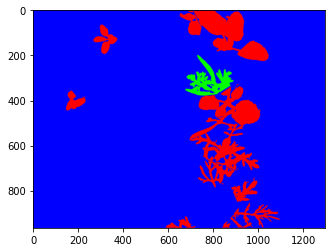

fcnresnet50 prediction:


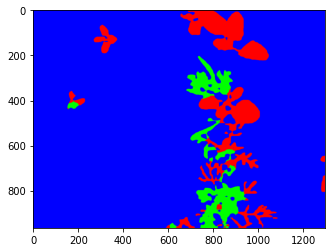

deeplabv3 prediction:


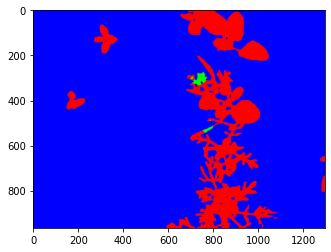

unet prediction:


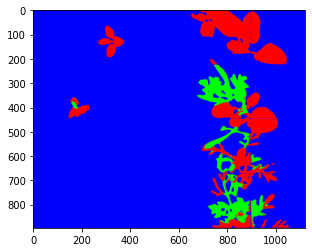

In [ ]:
# generate comparisons
patch_size = 224
patch_stride = 224

batch = iterator.next()
img = batch['image'].to(device)
annot = batch['annotation'].to(device)

output1 = fcnresnet50(img)['out']
output2 = deeplabv3(img)['out']

img_patches = F.unfold(img, patch_size, stride=patch_stride)

patch_num = img_patches.shape[2]
batch_size = img_patches.shape[0]
img_size = img_patches.shape[1]
img_patches = img_patches.permute(0,2,1)
img_patches = img_patches.reshape(patch_num * batch_size,  img_size)
img_patches = img_patches.view(patch_num * batch_size, 3, patch_size, patch_size)
output3 = unet(img_patches)

output3 = output3.view(patch_num * batch_size, 3 * patch_size * patch_size)
output3 = output3.permute(1,0)
output3 = output3.unsqueeze(0)
recon_out = F.fold(output3,(896,1120),patch_size,stride=patch_stride)

# Visualize
output = output1.squeeze() # single image
classes = torch.argmax(output, dim=0)
r = torch.zeros_like(classes)
g = torch.zeros_like(classes)
b = torch.zeros_like(classes)

idx = classes == 0
r[idx] = 1
idx = classes == 1
g[idx] = 1
idx = classes == 2
b[idx] = 1
  
fcnresnet_pred = torch.stack([r, g, b], axis=0).float()

output = output2.squeeze() # single image
classes = torch.argmax(output, dim=0)
r = torch.zeros_like(classes)
g = torch.zeros_like(classes)
b = torch.zeros_like(classes)

idx = classes == 0
r[idx] = 1
idx = classes == 1
g[idx] = 1
idx = classes == 2
b[idx] = 1
  
deeplabv3_pred = torch.stack([r, g, b], axis=0).float()

output = recon_out.squeeze() # single image
classes = torch.argmax(output, dim=0)
r = torch.zeros_like(classes)
g = torch.zeros_like(classes)
b = torch.zeros_like(classes)

idx = classes == 0
r[idx] = 1
idx = classes == 1
g[idx] = 1
idx = classes == 2
b[idx] = 1
  
unet_pred = torch.stack([r, g, b], axis=0).float()

print('ground truth:')
imshow(annot[0])
print('fcnresnet50 prediction:')
imshow(fcnresnet_pred)
print('deeplabv3 prediction:')
imshow(deeplabv3_pred)
print('unet prediction:')
imshow(unet_pred)